# Figure X.x - Supervised model performance

Goals : 

- Show that 3D models outperform usual 2D models

In [72]:
import numpy as np
from tifffile import imread
import sys
import numpy as np

import pyclesperanto_prototype as cle
from stardist.matching import matching_dataset
sys.path.append("../..")

from utils import *
from plots import *
print("Used GPU: ", cle.get_device())
show_params()
#################
SAVE_PLOTS_AS_PNG = False
SAVE_PLOTS_AS_SVG = False

Used GPU:  <Intel(R) UHD Graphics 620 on Platform: Intel(R) OpenCL (2 refs)>
Plot parameters (set in plots.py) : 
- COLORMAP : ██████████
- DPI : 200
- Data path : C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK
- Font size : 15
- Title font size : 26
- Label font size : 18


In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [74]:
data_path = DATA_PATH / "RESULTS/SUPERVISED_PERF_FIG/INFERENCE"
fold1_path = data_path / "fold1"
fold2_path = data_path / "fold2"
fold3_path = data_path / "fold3"

def get_fold_data(fold_path):
    return [imread(f) for f in fold_path.glob("*.tif") if "label" not in f.name], [imread(f) for f in fold_path.glob("*.tif") if "label" in f.name]

images = []
GT_labels = []
for fold in [fold1_path, fold2_path, fold3_path]:
    im, GT_lab = get_fold_data(fold)
    images.append(im)
    GT_labels.append(GT_lab)

In [75]:
fold_paths = [fold1_path, fold2_path, fold3_path]

def get_predictions(path):
    return [imread(f) for f in path.glob("*.tif")]
#################
swin_paths = [f / "Swin" for f in fold_paths]
segresnet_paths = [f / "SegResNet" for f in fold_paths]
#################
cellpose_paths = [f / "Cellpose" for f in fold_paths]
stardist_paths = [f / "stardist" for f in fold_paths]

swin_predictions = [get_predictions(p) for p in swin_paths]
segresnet_predictions = [get_predictions(p) for p in segresnet_paths]
cellpose_predictions = [get_predictions(p) for p in cellpose_paths]
stardist_predictions = [get_predictions(p) for p in stardist_paths]

In [76]:
# TEMP
fold_test = 0
swin = swin_predictions[fold_test][0]
segresnet = segresnet_predictions[fold_test][0]
cellpose = cellpose_predictions[fold_test][0]
# stardist = stardist_predictions[fold_test][0]

labels_gt = GT_labels[fold_test][0]

## Computations

In [77]:
swin_thresholded = np.where(swin > 0.5, swin, 0)
segresnet_thresholded = np.where(segresnet > 0.45, segresnet, 0)

In [78]:
swin_instance = cle.voronoi_otsu_labeling(swin_thresholded, spot_sigma=0.65, outline_sigma=0.65)
segresnet_instance = cle.voronoi_otsu_labeling(segresnet_thresholded, spot_sigma=0.65, outline_sigma=0.65)
swin_instance = np.array(swin_instance)
segresnet_instance = np.array(segresnet_instance)

In [79]:
# save_folder = data_path / "processed"
# save_folder.mkdir(exist_ok=True, parents=False)
# from tifffile import imwrite
# imwrite(save_folder / "swin_instance.tif", swin_instance)
# imwrite(save_folder / "segresnet_instance.tif", segresnet_instance)

## Plots

In [80]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predictions = [swin_instance,
               segresnet_instance,
               cellpose,
            #    stardist
               ]
names = ["Swin",
         "SegResNet",
         "Cellpose",
        #  "Stardist"
         ]

model_stats = []
model_ref_name = []

Validating on Swin
********************
Validating on SegResNet
********************
Validating on Cellpose
********************


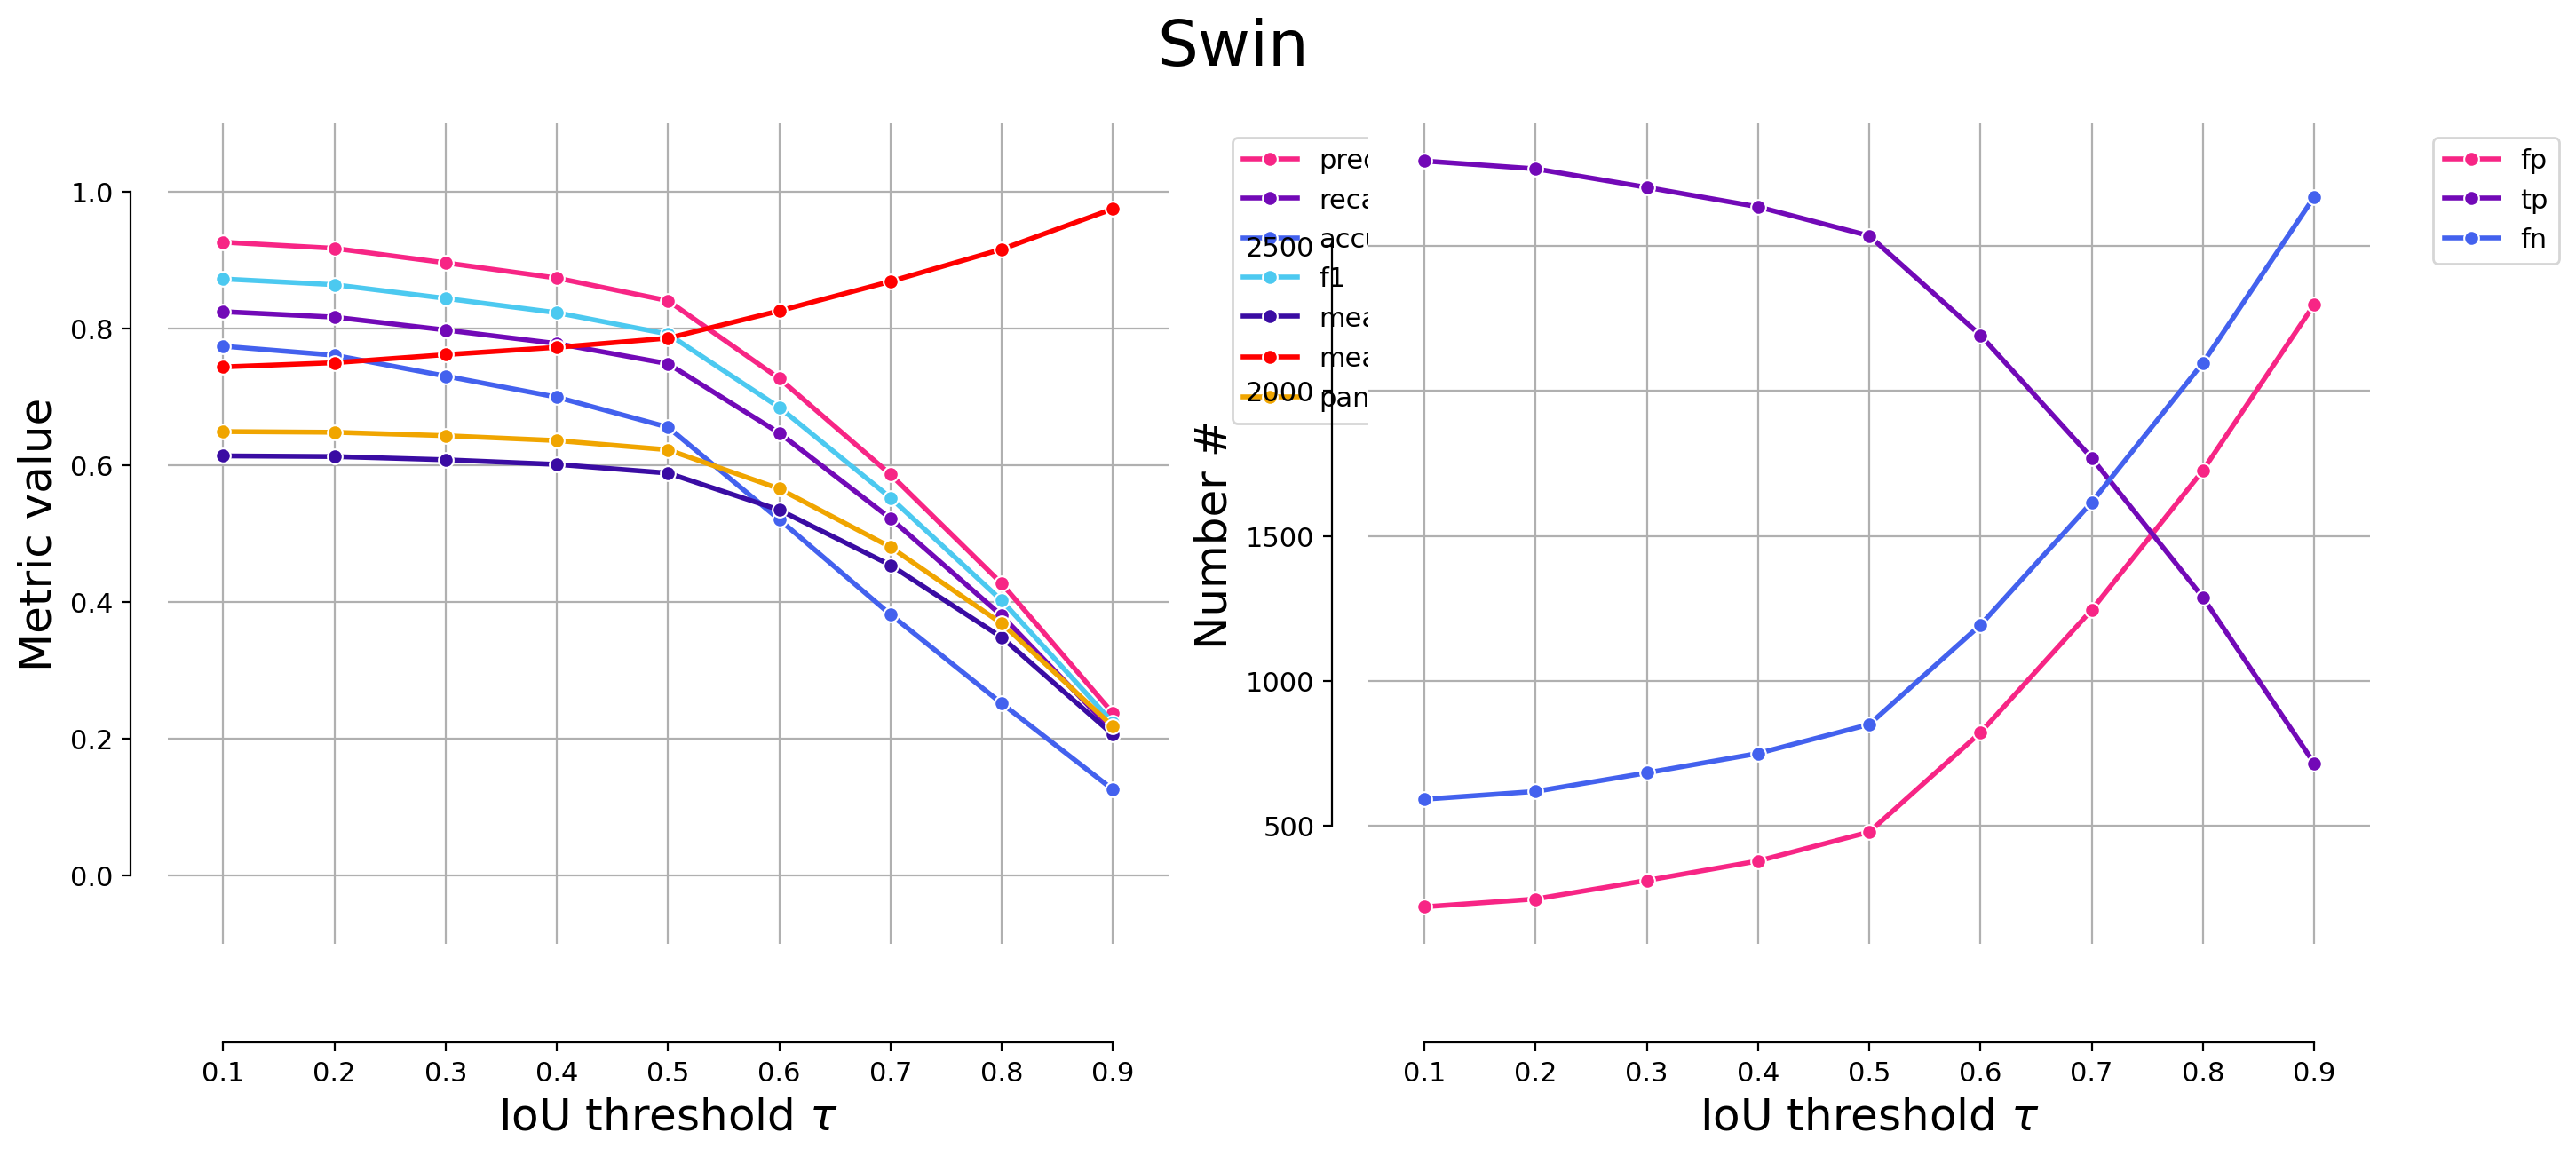

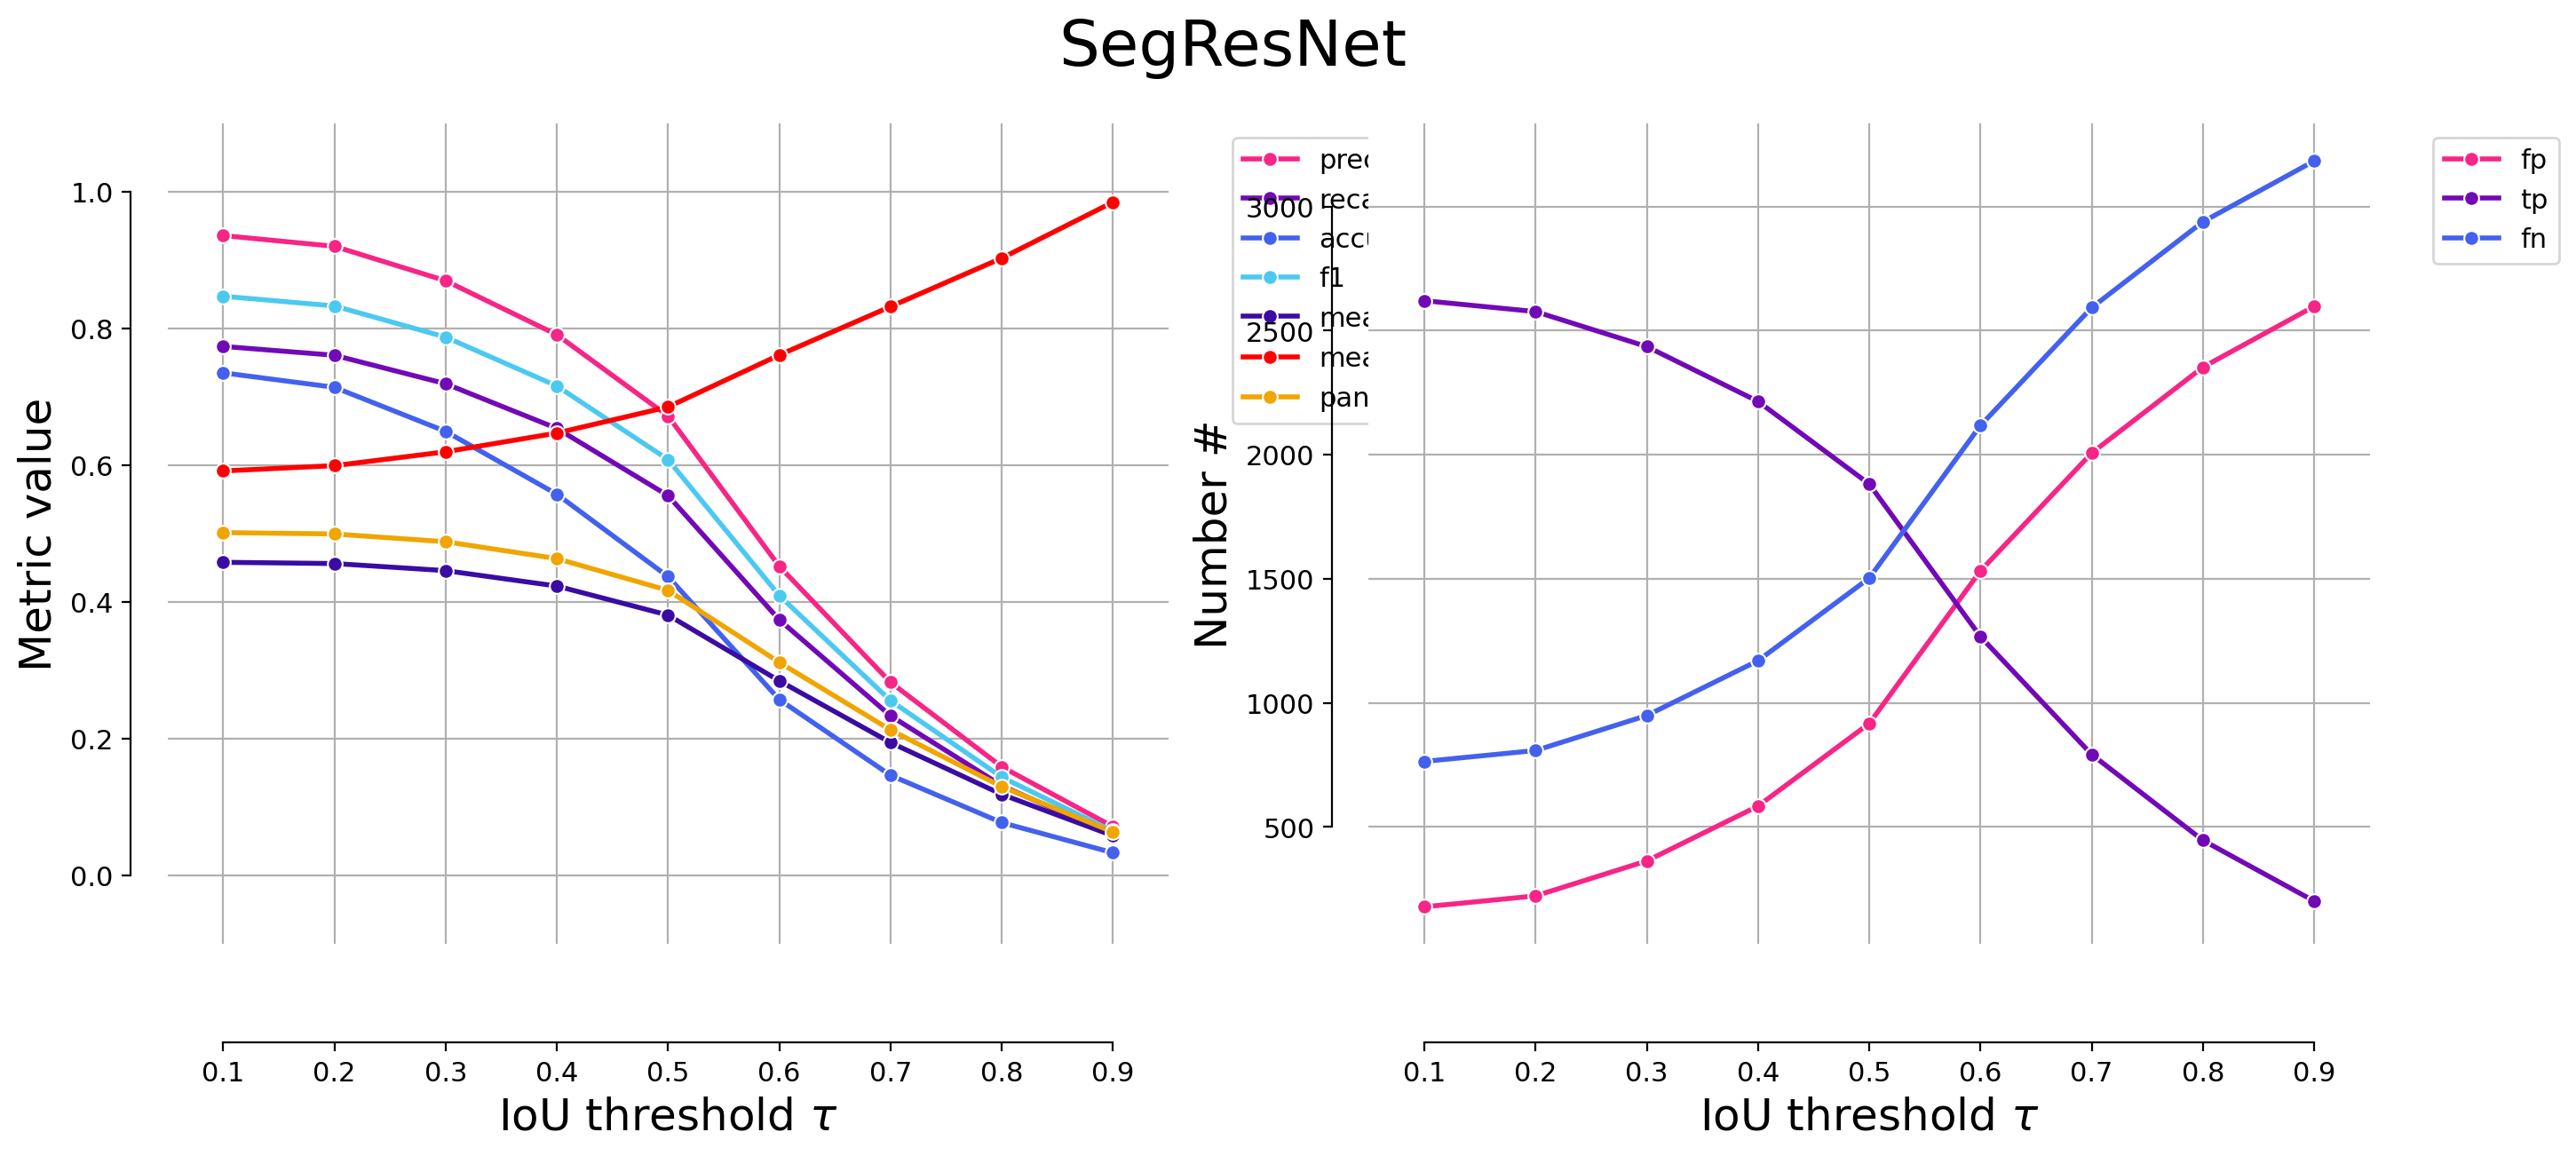

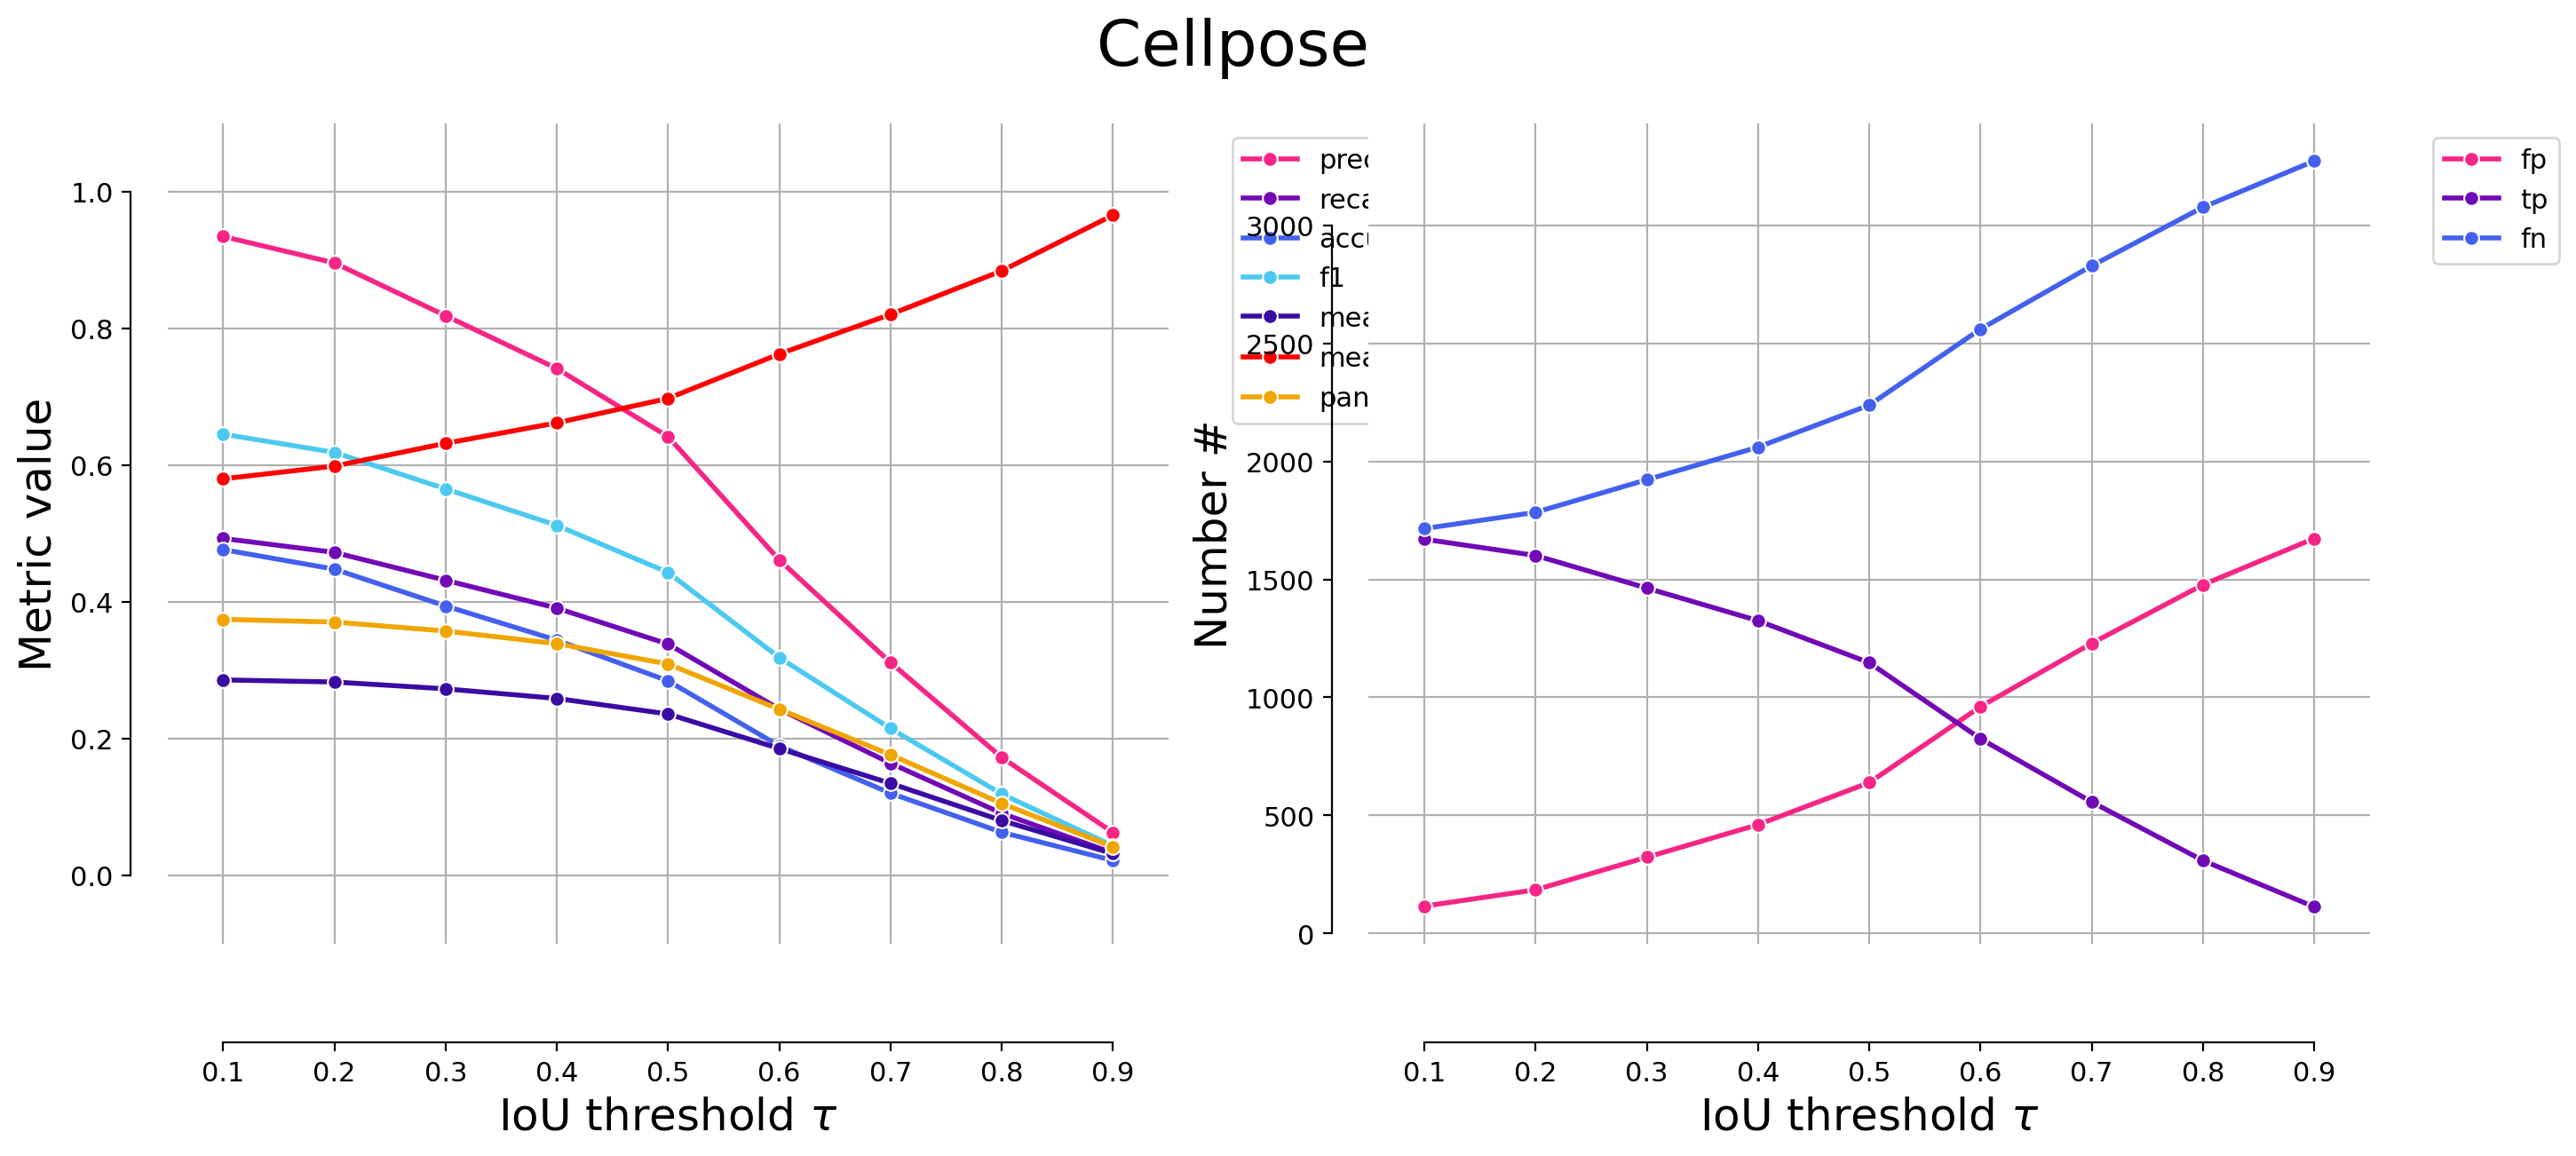

In [81]:

for i, p in enumerate(predictions):
    print(f"Validating on {names[i]}")
    stats = [matching_dataset(
        labels_gt, p, thresh=t, show_progress=False
        ) for t in taus]
    model_stats.append(stats)
    model_ref_name.append(names[i])
    # fold_ref.append()
    plot_performance(taus, stats, name=names[i])
    print("*"*20)

In [82]:
dfs = [dataset_matching_stats_to_df(s) for s in model_stats]
df = pd.concat(dfs)
df

,criterion,fp,tp,fn,precision,recall,accuracy,f1,n_true,n_pred,mean_true_score,mean_matched_score,panoptic_quality,by_image
thresh,,,,,,,,,,,,,,
0.1,iou,221,2793,592,0.926676,0.825111,0.774542,0.872949,3385,3014,0.614096,0.744259,0.649700,False
0.2,iou,248,2766,619,0.917717,0.817134,0.761354,0.864510,3385,3014,0.613144,0.750359,0.648693,False
0.3,iou,312,2702,683,0.896483,0.798227,0.730863,0.844507,3385,3014,0.608406,0.762196,0.643680,False
0.4,iou,379,2635,750,0.874253,0.778434,0.700053,0.823566,3385,3014,0.601647,0.772894,0.636529,False
0.5,iou,479,2535,850,0.841075,0.748892,0.656056,0.792311,3385,3014,0.588905,0.786368,0.623048,False
0.6,iou,822,2192,1193,0.727273,0.647563,0.521036,0.685107,3385,3014,0.535068,0.826280,0.566090,False
0.7,iou,1245,1769,1616,0.586928,0.522600,0.382073,0.552899,3385,3014,0.454304,0.869316,0.480644,False
0.8,iou,1726,1288,2097,0.427339,0.380502,0.252005,0.402563,3385,3014,0.348681,0.916370,0.368896,False
0.9,iou,2298,716,2669,0.237558,0.211521,0.125990,0.223785,3385,3014,0.206350,0.975553,0.218314,False


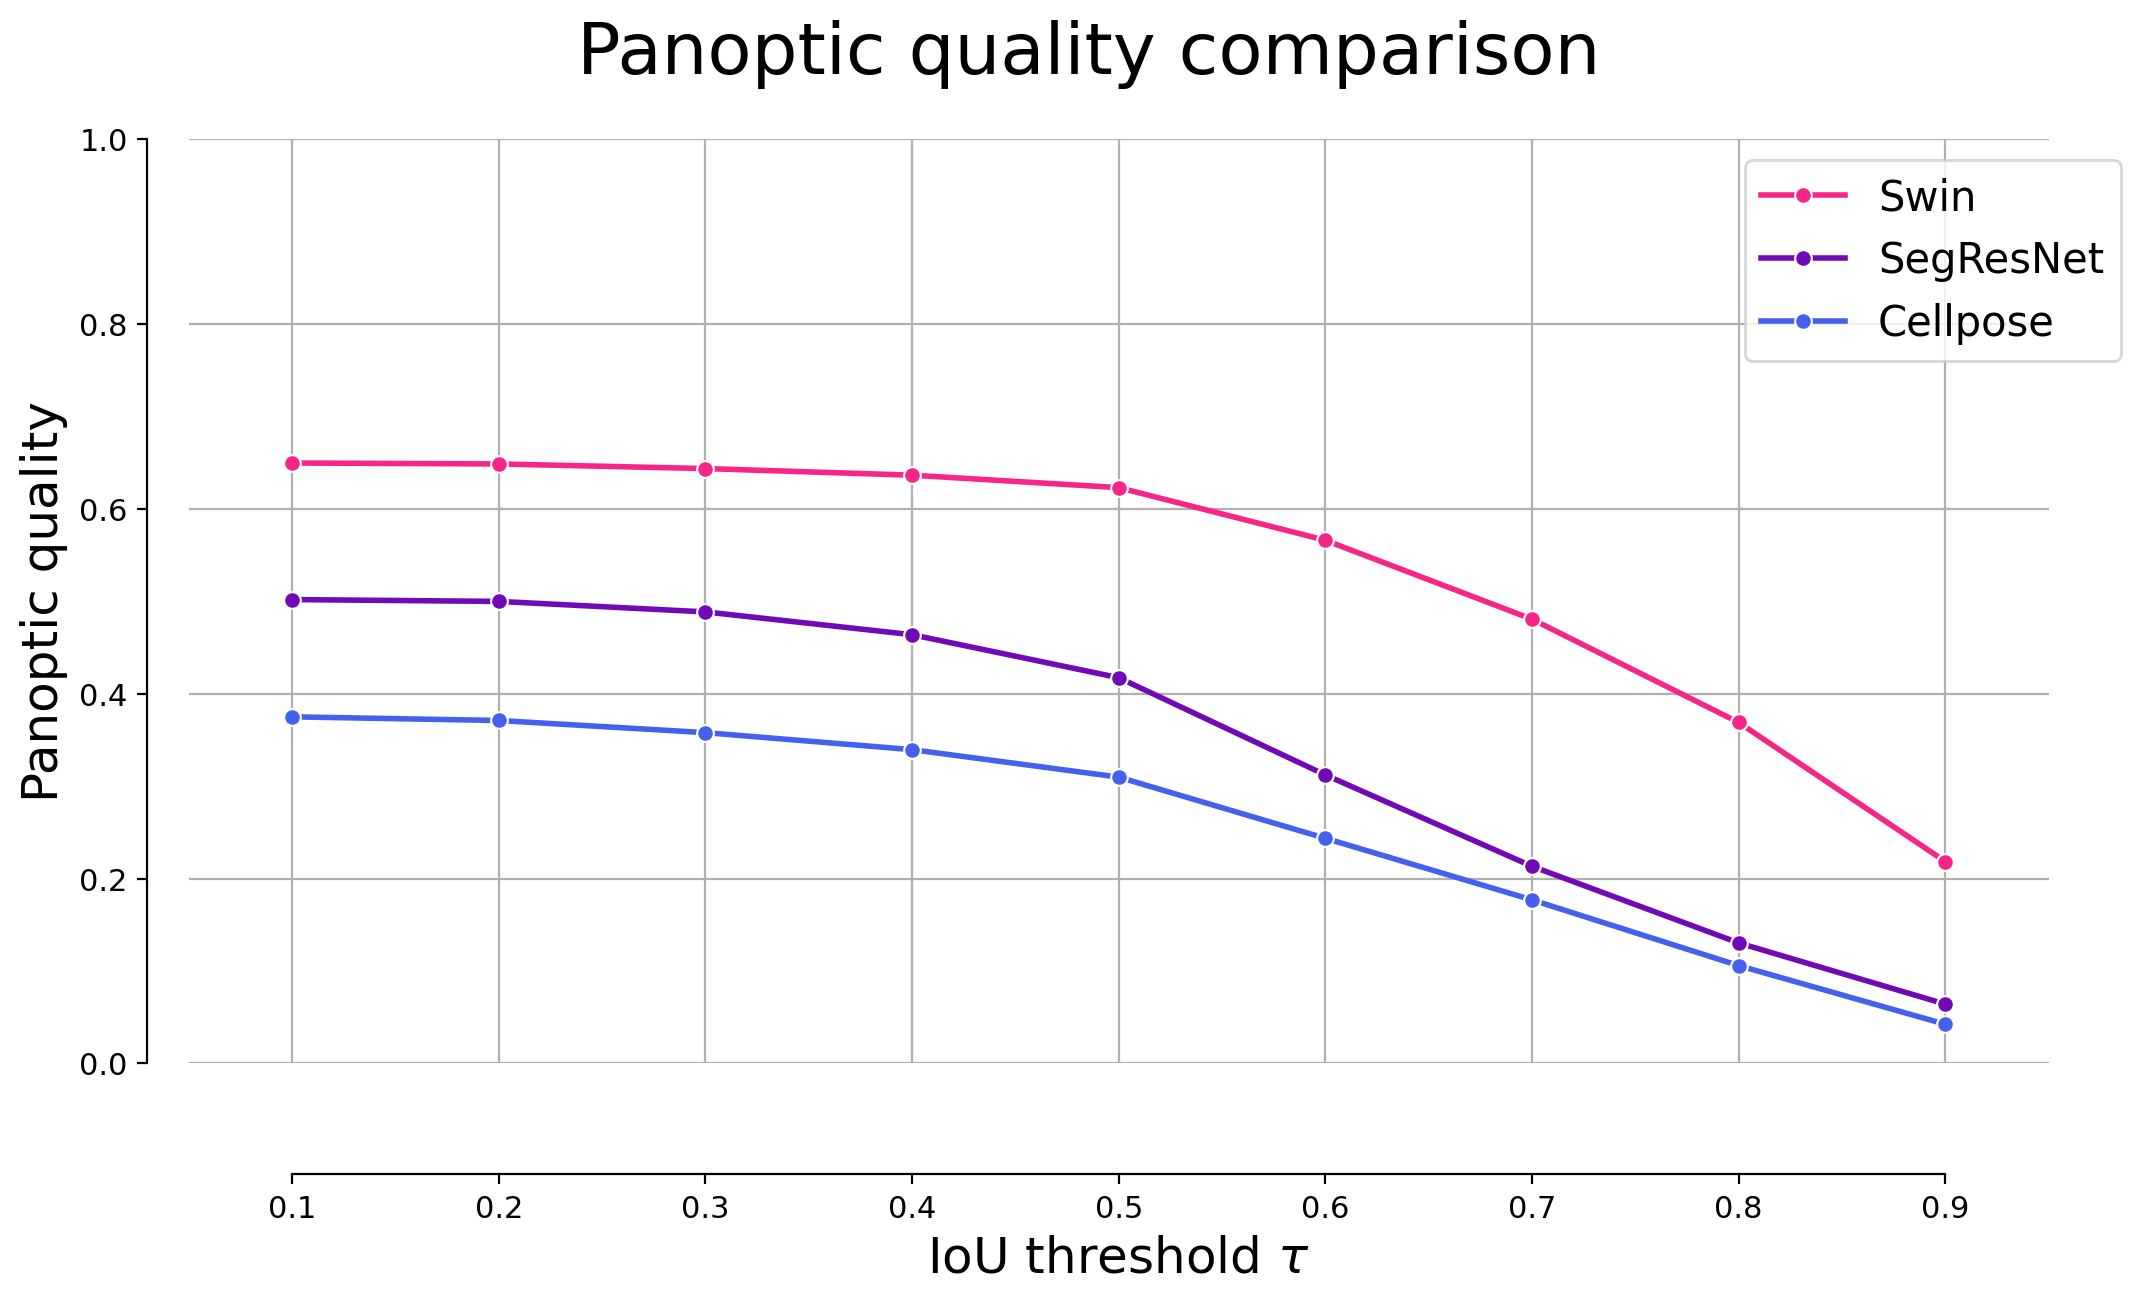

In [83]:
plot_stat_comparison(taus, model_stats, names, stat="panoptic_quality")
if SAVE_PLOTS_AS_PNG:
    plt.savefig("panoptic_quality.png", dpi=DPI, format="png", bbox_inches='tight')
if SAVE_PLOTS_AS_SVG:
    plt.savefig("panoptic_quality.svg", format="svg")

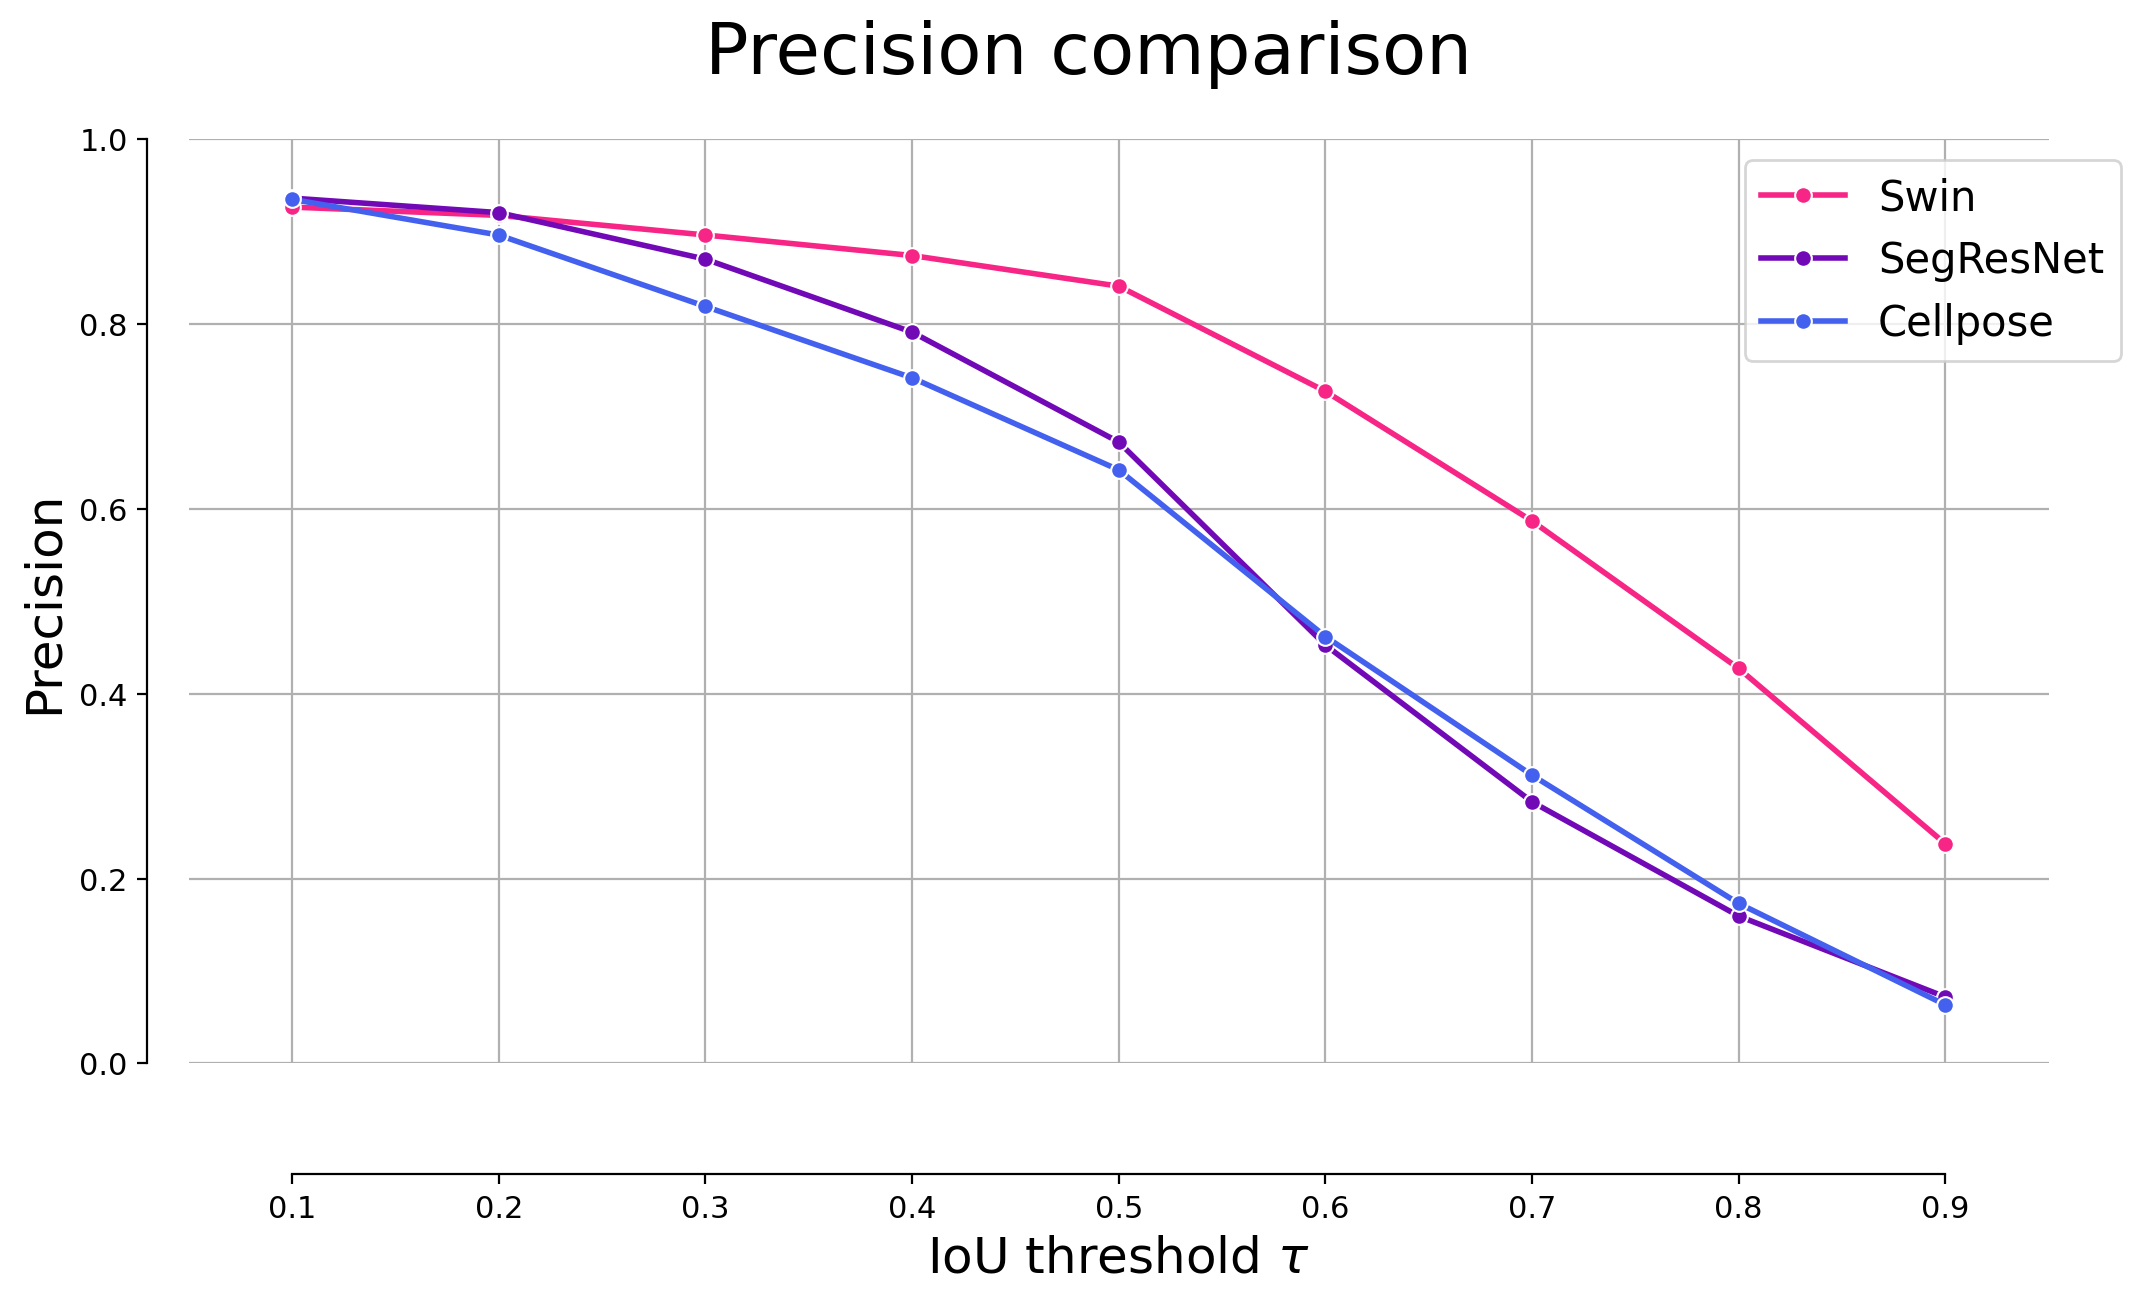

In [84]:
plot_stat_comparison(taus, model_stats, names, stat="precision")

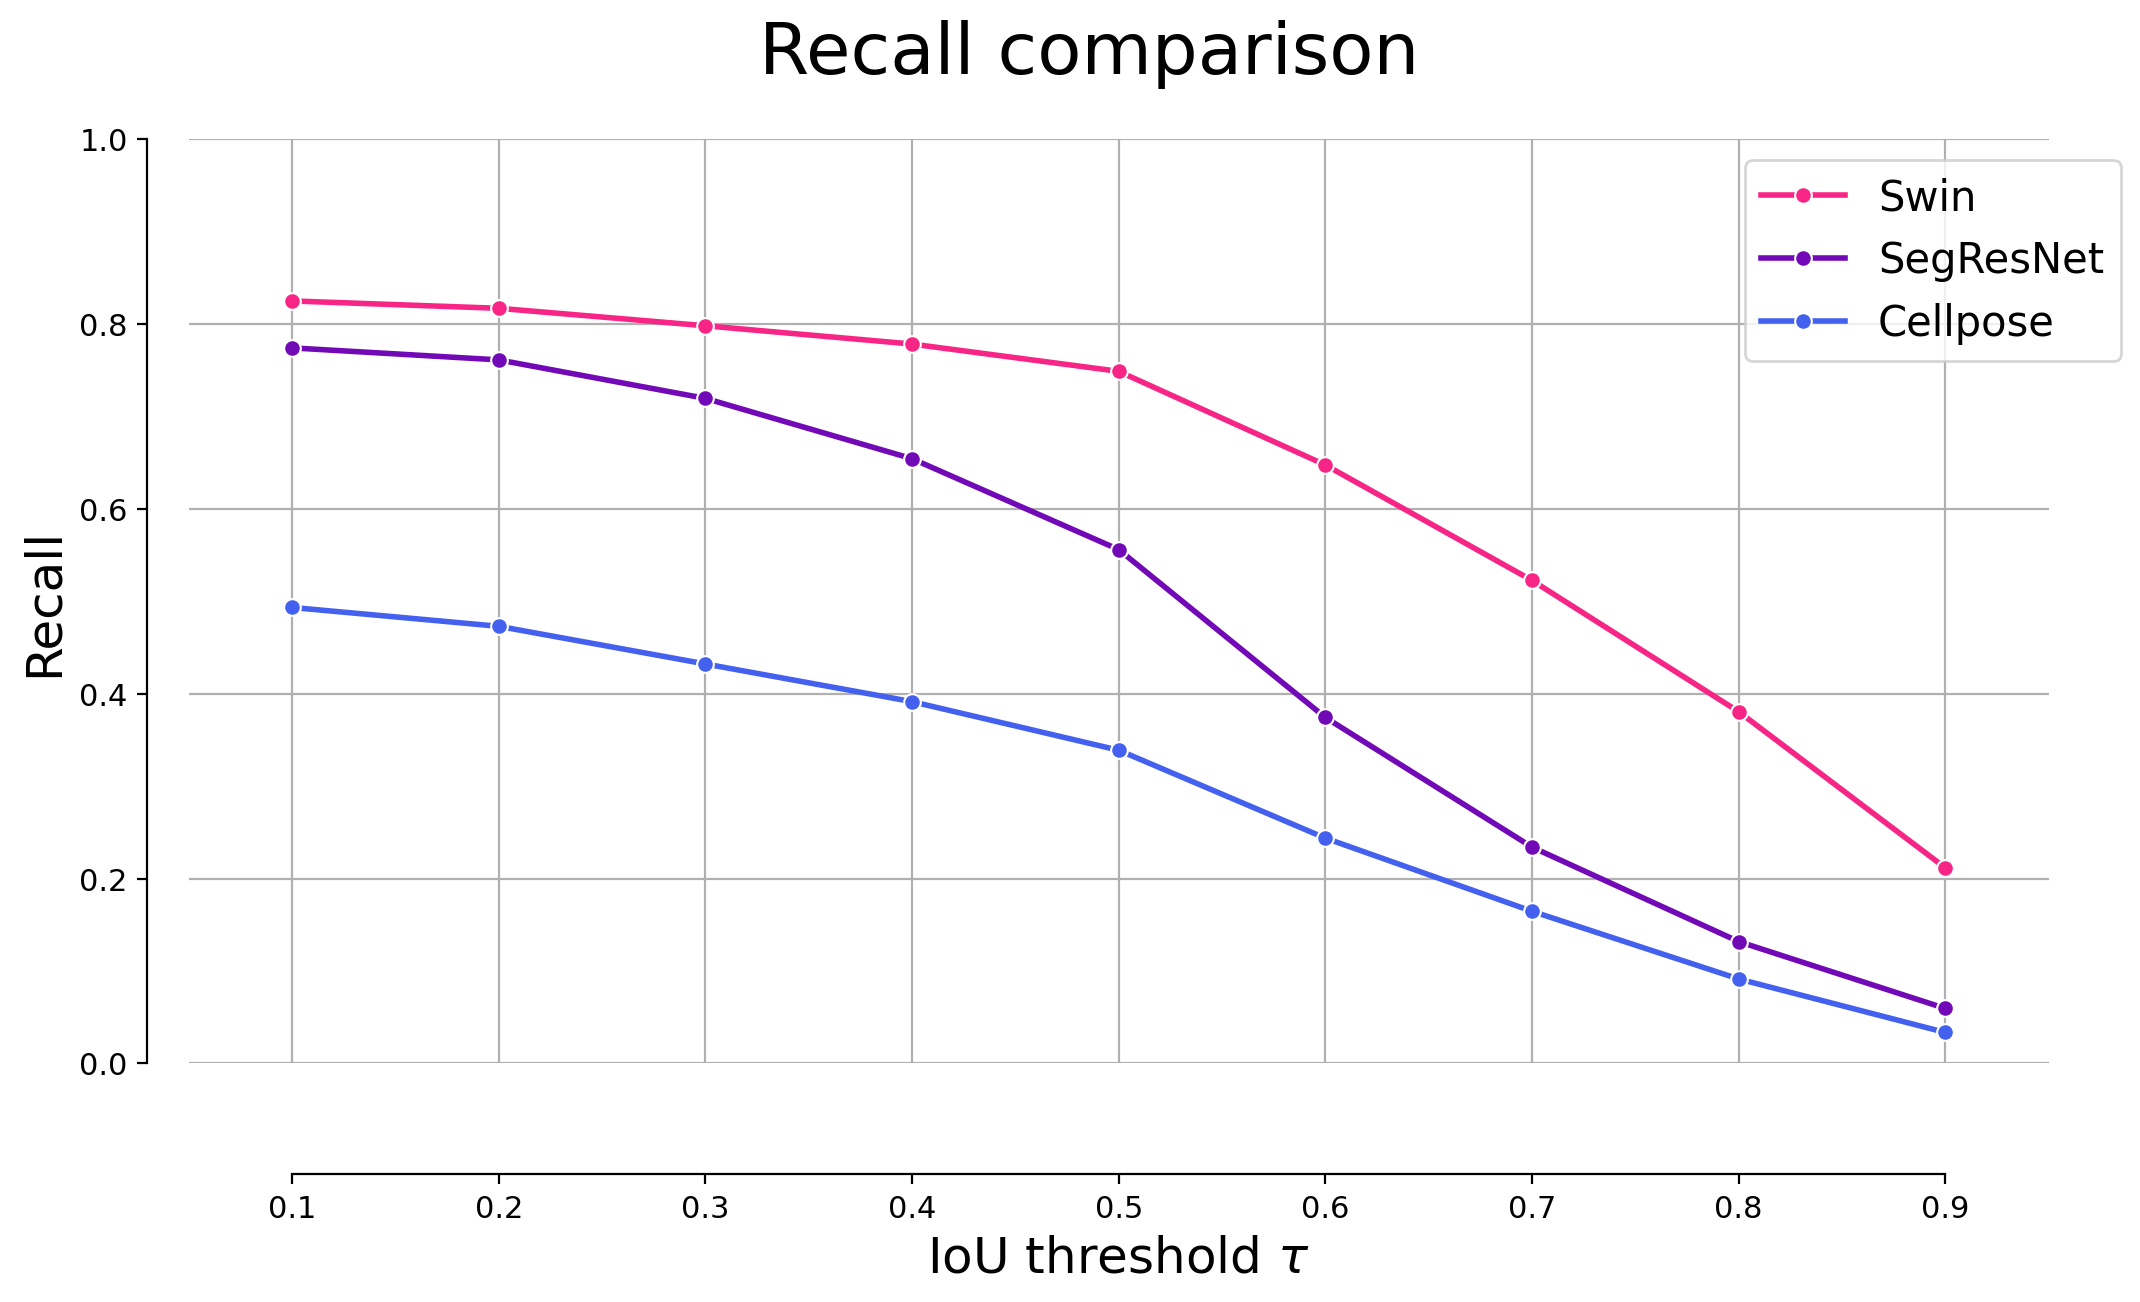

In [85]:
plot_stat_comparison(taus, model_stats, names, stat="recall")

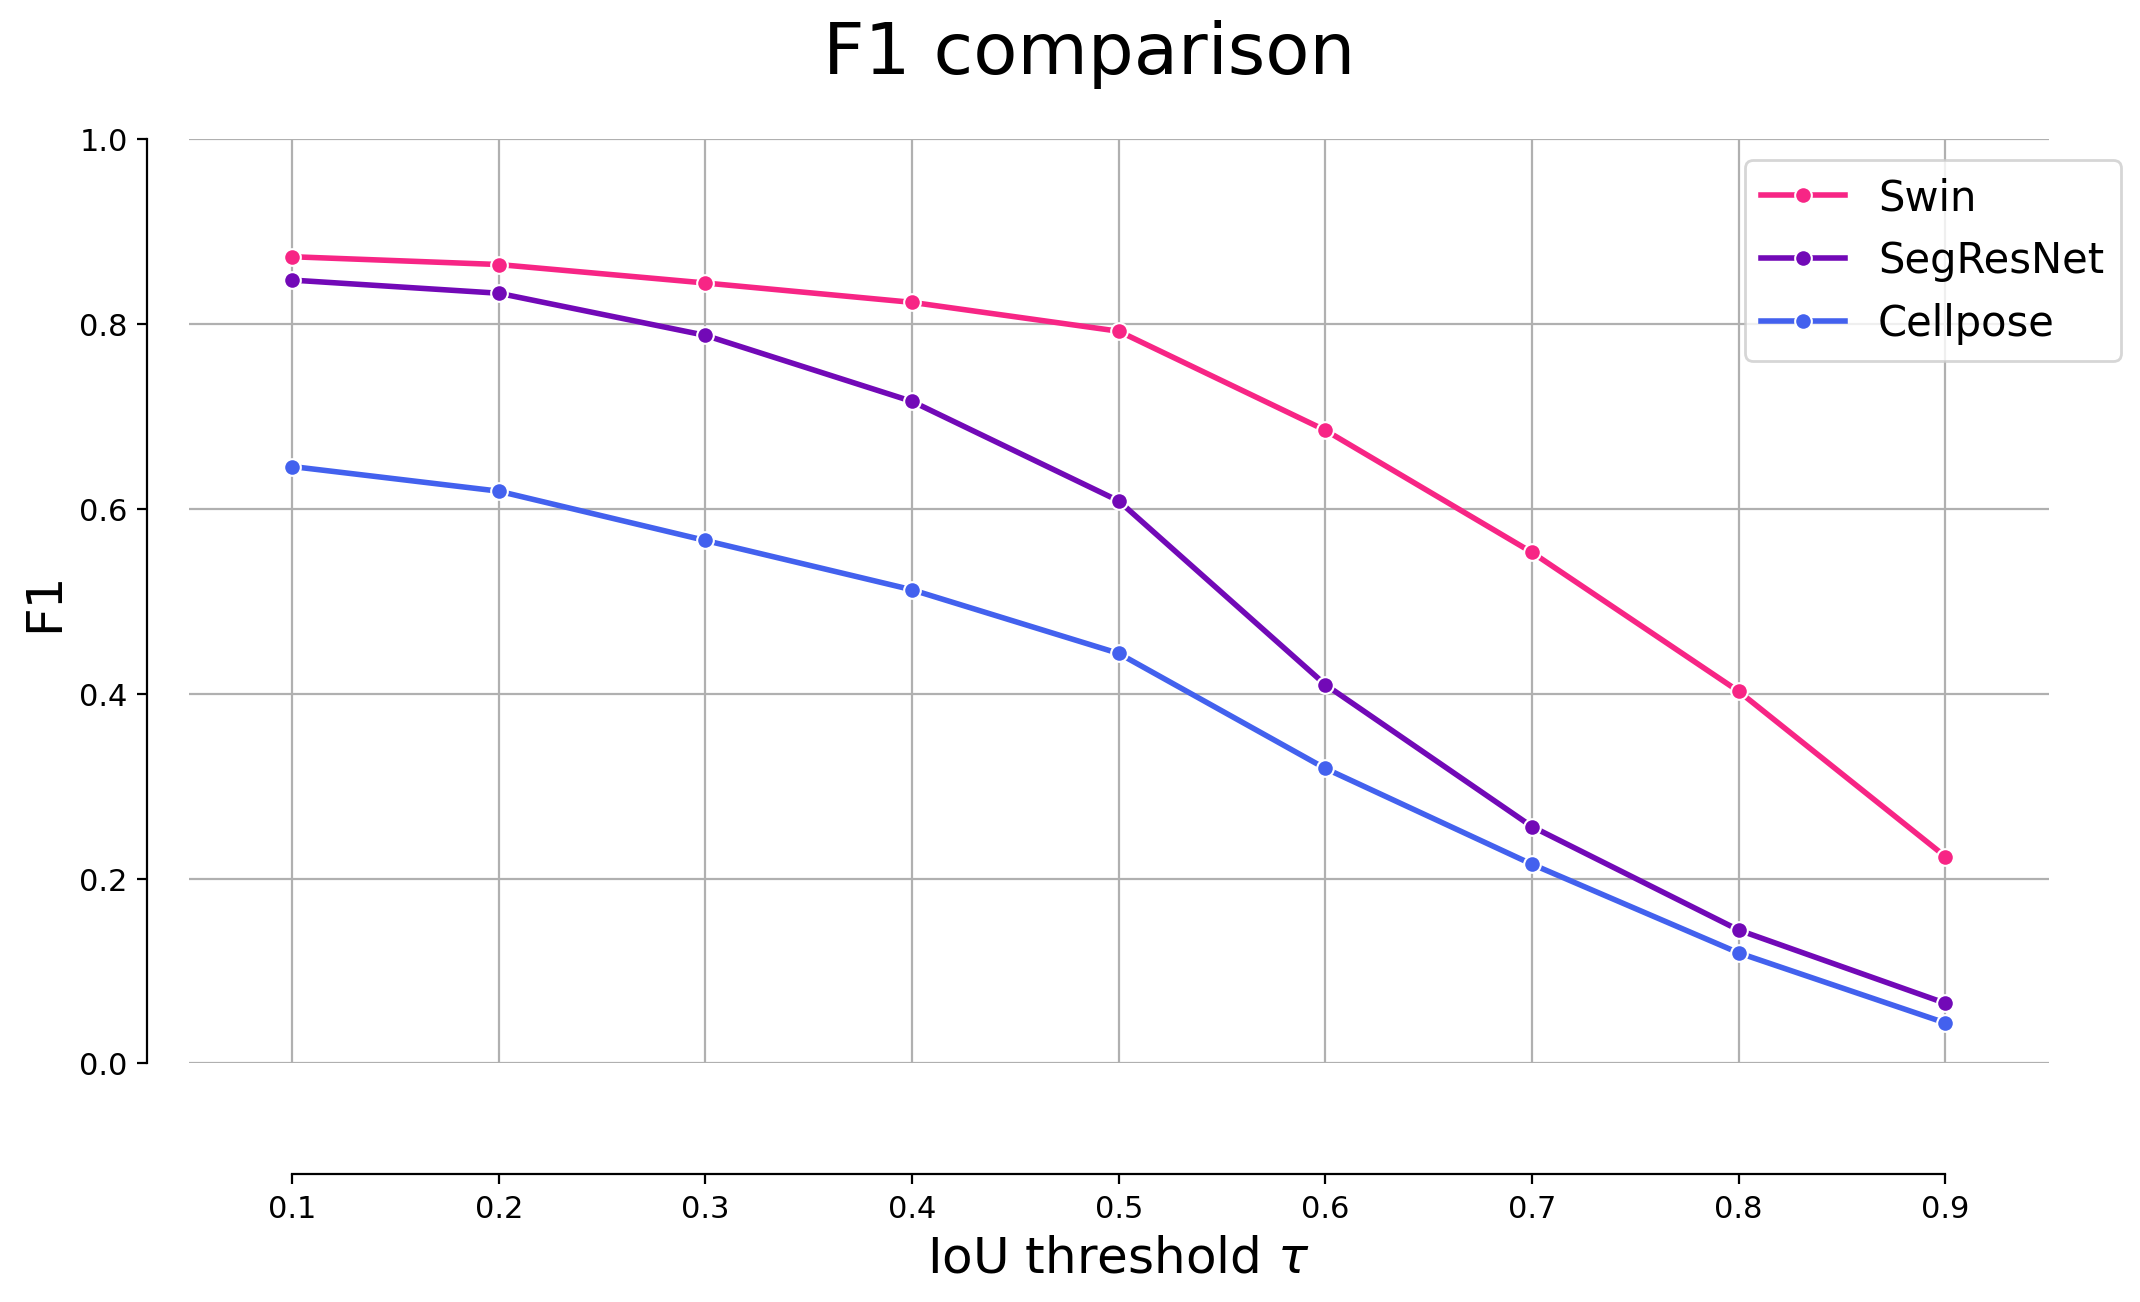

In [86]:
plot_stat_comparison(taus, model_stats, names, stat="f1")